# Defense Wins Championships

It has been said that defense wins championships. Well, more precisely, the saying goes, "Offense wins games, defense wins championships." So I want to take a look at how offenses and defenses affect the chances of a team winning a given game. I will take a look the past 10 seasons of NFL games as the basis for my study. The regular season games will be used to build two models: offensive and defensive. Then I will test the models with the playoff data from the same 10 seasons to see which model is more accurate which will tell us whether defense truly is what wins championships.

## Hypothesis

Having a good offense is effective in winning regular season games, but in order to win championships, rather, playoff games leading to and including the championship game, defense will be what makes the difference.

## Method

I will gather offensive and defensive stats from the past 10 NFL seasons. They will be divided into regular season and postseason(playoff) games. The regular season games will be the dataset on which I will be training the models and the postseason data will be used to test the models. Each NFL season has 256 games (16 games/week x 16 weeks/season) for a total of 2560 games. For the purposes of this exercise, I will randomly pick 1000 games since the method of gathering each game data is labor intensive. In the postseason, 12 teams qualify and play a total of 11 games(4-wild card, 4-divisional, 2-conference, and the Super Bowl). That equates to 110 postseason games which would be roughly 10% of the size of the training dataset. Then I will compare the offensive model prediction accuracy with that of the defensive model to prove that defense is what makes a championship winning team.

## Data

The method which I will be gathering the data will be brute-force which is why it will be labor-intensive. I will be using the website www.pro-football-reference.com to convert the game stats to csv by copying the offense and defense game data on to a spreadsheet and then exporting it as a .csv file.

In [64]:
# Let's load the necessary packages and the data
import numpy as np
import pandas as pd
import pandas_profiling
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import time

### Offense Dataset

In [218]:
# import data
col_names = ['win', 'venue', 'score', 'opp_score', 'completions', 'pass_att', 'pass_yds', 'pass_tds',
              'interceptions', 'sacks', 'yds_lost', 'yds_per_pass_att', 'comp_%', 'qb_rtg',
              'rush_att', 'rush_yds', 'yds_per_rush_att', 'rush_tds', 'fgs_made', 'fg_att',
              'x_pts_made', 'x_pt_att', 'punts', 'punt_yds', '3_down_conv', '3_down_att', 
              '4_down_conv', '4_down_att', 'time_of_poss']

offense = pd.read_csv('../../../Data/offense.csv', header=None, names=col_names)
#offense.head(5)

Let's fix the 'win' and 'venue' columns.

In [220]:
# first change 'win' column values from string to number type
offense['win'] = np.where(offense['win'] == 'W', 1, 0)

# change venue to more descriptive value
offense['venue'] = np.where(offense['venue'] == '@', 'away', 'home')

# we don't need to know the opponent's score for the offensive model so let's drop that column
offense = offense.drop(['opp_score'], axis=1)

display(offense.head(5))

,win,venue,score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,yds_lost,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
0,0,home,16,26,44,259,1,2,3,29,...,3,1,1,6,328,4,14,0,1,28:23
1,1,away,31,27,32,265,2,0,0,0,...,2,4,4,3,139,2,9,1,1,31:21
2,0,home,21,27,46,226,2,5,2,16,...,0,3,3,4,210,4,10,1,2,27:02
3,1,away,41,22,33,256,5,1,1,5,...,2,5,5,4,166,8,14,0,0,33:16
4,1,home,31,29,38,340,2,0,0,0,...,1,4,4,7,364,2,12,1,2,31:30


That leaves us with the last column in the dataframe that contains the time of possession value as a string. We would need to convert these to numerical values to be able to get meaningful information.

In [222]:
# change 'time_of_poss' values to duration in seconds
# check to see if any values are different than mm:ss
print(offense[offense['time_of_poss'].str.len() < 5])

     win venue  score  completions  pass_att  pass_yds  pass_tds  \
19     0  away      7           30        53       201         1   
35     1  home     23           22        40       257         1   
51     0  away     13           19        34       207         1   
67     0  home     20           28        49       399         2   
82     0  away     17           23        40       299         2   
98     0  home      6           20        43       205         1   
287    1  away     21           11        19        90         0   
547    0  away     16           18        32       207         1   

     interceptions  sacks  yds_lost  ...  fg_att  x_pts_made  x_pt_att  punts  \
19               2      6        41  ...       0           1         1      8   
35               1      2        14  ...       3           2         2      7   
51               1      2        18  ...       2           1         1      6   
67               1      1         8  ...       4           2   

In [223]:
# fix incomplete data
offense.at[19, 'time_of_poss'] = '32:40'
offense.at[35, 'time_of_poss'] = '35:00'
offense.at[51, 'time_of_poss'] = '23:50'
offense.at[67, 'time_of_poss'] = '32:00'
offense.at[82, 'time_of_poss'] = '30:30'
offense.at[98, 'time_of_poss'] = '23:20'
offense.at[287, 'time_of_poss'] = '27:00'
offense.at[547, 'time_of_poss'] = '32:20'

In [224]:
# first need to change the format from mm:ss to hh:mm:ss
offense['time_of_poss'] = ['00:' + x for x in offense['time_of_poss']]
# print(offense['time_of_poss'])

In [225]:
# convert strings to seconds 
offense['time_of_poss'] = pd.to_timedelta(offense['time_of_poss'], 'seconds')

In [233]:
# Let's gather some stats on the stats
pandas_profiling.ProfileReport(offense)

Number of variables,28
Number of observations,1000
Total Missing (%),0.0%
Total size in memory,218.8 KiB
Average record size in memory,224.1 B
Numeric,22
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,3


### Defense Dataset

In [229]:
defense = pd.read_csv('../../../Data/defense.csv', header=None, names=col_names)
defense.head(5)

,win,venue,score,opp_score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
0,L,@,23,35,29,41,285,4,1,1,...,1,2,2,5,189,8,16,0,1,33:20
1,W,@,16,13,20,37,190,0,1,4,...,2,1,1,7,303,8,18,0,0,33:09
2,L,NaN,17,28,13,18,174,2,0,1,...,0,4,4,7,311,2,9,0,0,23:45
3,W,NaN,18,15,24,49,210,0,1,3,...,5,0,0,7,351,5,19,1,1,33:13
4,L,@,7,34,21,30,297,4,1,1,...,2,4,4,3,129,9,14,0,0,35:47


In [230]:
# rinse, repeat for defense df
defense['win'] = np.where(defense['win'] == 'W', 1, 0)
defense['venue'] = np.where(defense['venue'] == '@', 'away', 'home')
defense = defense.drop(['score'], axis=1)
display(defense.head(5))

,win,venue,opp_score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,yds_lost,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
0,0,away,35,29,41,285,4,1,1,7,...,1,2,2,5,189,8,16,0,1,33:20
1,1,away,13,20,37,190,0,1,4,26,...,2,1,1,7,303,8,18,0,0,33:09
2,0,home,28,13,18,174,2,0,1,9,...,0,4,4,7,311,2,9,0,0,23:45
3,1,home,15,24,49,210,0,1,3,24,...,5,0,0,7,351,5,19,1,1,33:13
4,0,away,34,21,30,297,4,1,1,7,...,2,4,4,3,129,9,14,0,0,35:47


In [231]:
# we need to do the same for the defense dataset
print(defense[defense['time_of_poss'].str.len() < 5])

    win venue  opp_score  completions  pass_att  pass_yds  pass_tds  \
72    1  home         13           29        43       397         1   

    interceptions  sacks  yds_lost  ...  fg_att  x_pts_made  x_pt_att  punts  \
72              3      0         0  ...       0           1         1      2   

    punt_yds  3_down_conv  3_down_att  4_down_conv  4_down_att  time_of_poss  
72        91            2           8            0           2          22:2  

[1 rows x 28 columns]


In [232]:
#fix string and convert to time duration in seconds
defense.at[72, 'time_of_poss'] = '22:20'
defense['time_of_poss'] = ['00:' + x for x in defense['time_of_poss']]
defense['time_of_poss'] = pd.to_timedelta(defense['time_of_poss'], 'seconds')
print(defense['time_of_poss'].dtype)

timedelta64[ns]


In [234]:
pandas_profiling.ProfileReport(defense)

Number of variables,28
Number of observations,1000
Total Missing (%),0.0%
Total size in memory,218.8 KiB
Average record size in memory,224.1 B
Numeric,22
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,3


For both offense and defense data it's good to see that the venue and win column values are evenly distributed between two possibilities. On a cursory glance at least it looks like we have a random sample of games from the past 10 seasons. But let's visualize our data to examine it deeper.

## Visualizations

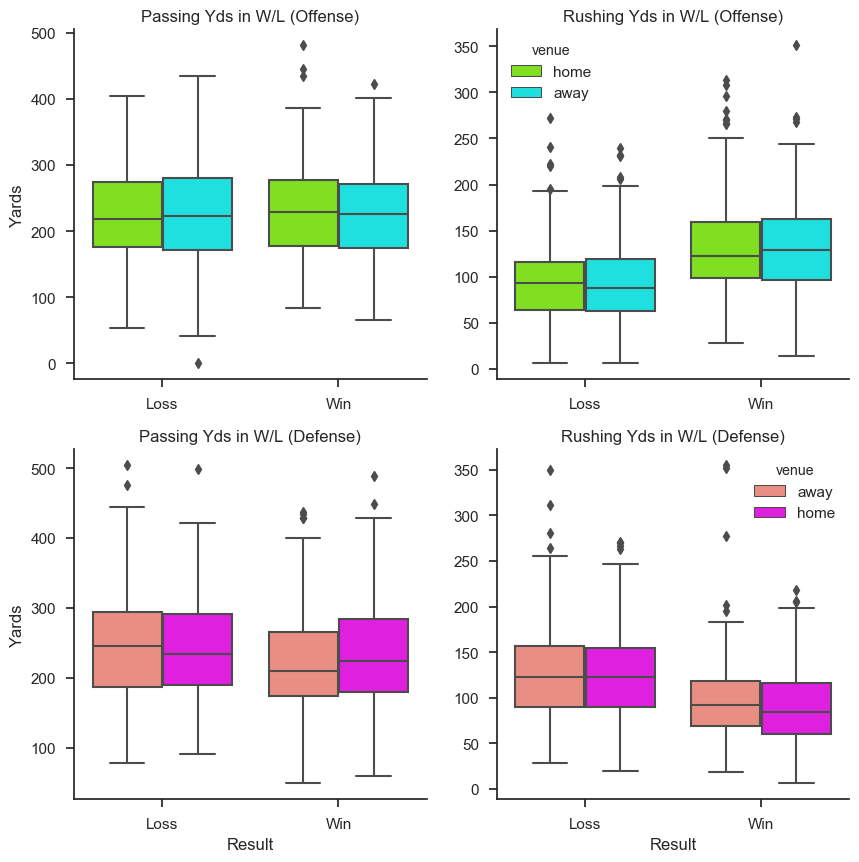

In [158]:
f, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.set(style='ticks')
sns.despine()

x = 'win'
hue = 'venue'

ax1 = axes[0, 0]
sns.boxplot(x=x, y='pass_yds', hue=hue, data=offense, ax=ax1, palette=['chartreuse', 'aqua'])
ax1.set_title('Passing Yds in W/L (Offense)')
ax1.set_ylabel('Yards')
ax1.set_xlabel('')
ax1.get_legend().remove()
ax1.set_xticklabels(['Loss', 'Win'])

ax2 = axes[0, 1]
sns.boxplot(x=x, y='rush_yds', hue=hue, data=offense, ax=ax2, palette=['chartreuse', 'aqua'])
ax2.set_title('Rushing Yds in W/L (Offense)')
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_xticklabels(['Loss', 'Win'])

ax3 = axes[1, 0]
sns.boxplot(x=x, y='pass_yds', hue=hue, data=defense, ax=ax3, palette=['salmon', 'magenta'])
ax3.set_title('Passing Yds in W/L (Defense)')
ax3.set_ylabel('Yards')
ax3.set_xlabel('Result')
ax3.get_legend().remove()
ax3.set_xticklabels(['Loss', 'Win'])

ax4 = axes[1, 1]
sns.boxplot(x=x, y='rush_yds', hue=hue, data=defense, ax=ax4, palette=['salmon', 'magenta'])
ax4.set_title('Rushing Yds in W/L (Defense)')
ax4.set_ylabel('')
ax4.set_xlabel('Result')
ax4.set_xticklabels(['Loss', 'Win'])

plt.show()

That is certainly interesting. Passing yards doesn't show much difference between wins and losses, but there definitely is a trend of winning teams gaining more rush yards than losing teams. There is also a very peculiar outlier for passing yards in an away team loss. 0 passing yards? That seems hard to believe in today's pass-happy offenses. So let's see if this is erroneous or an actual game record.

In [116]:
# find the record that has 0 passing yards
no_pass_yds = offense[offense['pass_yds'] == 0]
display(no_pass_yds)

,win,venue,score,opp_score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
862,0,away,0,37,4,19,0,0,1,3,...,0,0,0,7,275,1,11,1,1,18:46


Ahh. So it looks like this definitely wasn't an erroneous record. This team completed only 4 passes in 19 passing attempts in a shutout loss. Definitely won't win too many games with this kind of offense. I have a strong suspicion that this was a 16-loss team (read: Browns or Raiders) game that went horribly wrong. Or maybe, just maybe, it could be a relic of dark times in my Broncos' history that was Tim Tebow-led offense that still gives me the shudders to this day everytime I think about it.

Since we are dealing with sports statistic, it is inevitable that certain varaibles will be closely correlated. The score will obviously be correlated to touchdowns scored, pass yards will be correlated to pass completions and so on. I want to plot each to quantify to relationships and see if we can eliminate some that are highly redundant.

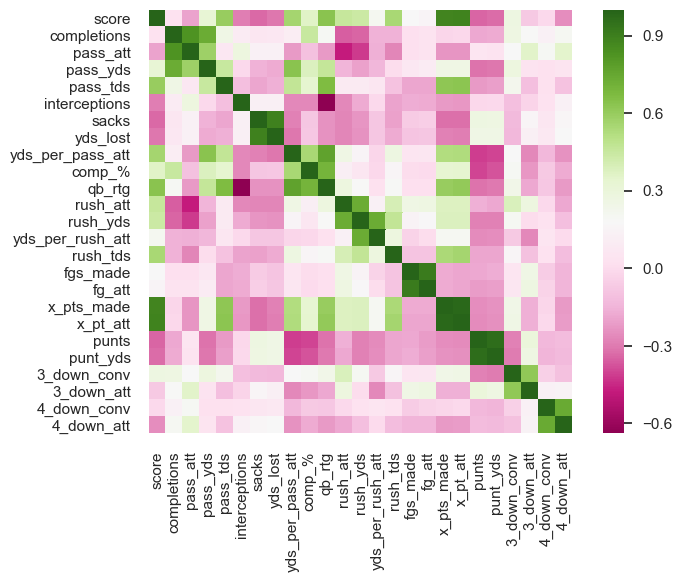

In [170]:
# Let's pull the relevant data from the table and store it
off_features = offense.drop(['win'], axis=1)

# Let's plot a matrix
corrmat = off_features.corr()

sns.set(style='white')
sns.despine()

sns.heatmap(data=corrmat, cmap="PiYG", square=True)

plt.show()

I think this correlation matrix doesn't look too bad. Relatively speaking the only one I may have take a closer look at is the relationship between qb_rtg and interceptions. x_pts_made and x_pt_att is most definitely redundant since it was almost a given that kickers made the extra point attempts and sports do not play well with "a sure thing." This is mainly the reason that the league moved the extra point attempts from the 3-yard line to the 15-yard line. 

In [171]:
# remove x_pt_att
off_features = off_features.drop(['x_pt_att'], axis=1)

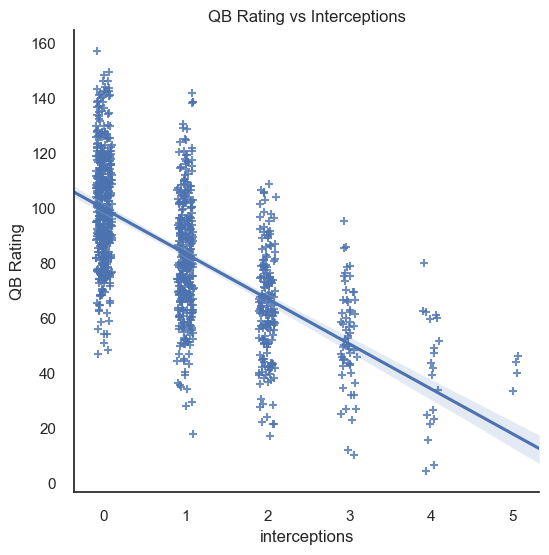

In [161]:
# Plot qb_rtg vs interceptions
f, ax = plt.subplots(figsize=(6, 6))
sns.set(style='ticks')
sns.despine()

sns.regplot(x='interceptions', y='qb_rtg', data=offense, x_jitter=0.1, marker='+')

plt.title('QB Rating vs Interceptions')
plt.ylabel('QB Rating')
plt.show()

That's a pretty strong correlation. Each interception results in about 20 point drop in QB rating. Since the way QB rating is calculated in unclear other than the fact that it incorporates all the things a QB does such as pass yards and touchdowns, let's drop QB rating from our features set.

In [172]:
# drop qb_rtg from features
off_features = off_features.drop('qb_rtg', axis=1)
off_features.columns

Index(['venue', 'score', 'completions', 'pass_att', 'pass_yds', 'pass_tds',
       'interceptions', 'sacks', 'yds_lost', 'yds_per_pass_att', 'comp_%',
       'rush_att', 'rush_yds', 'yds_per_rush_att', 'rush_tds', 'fgs_made',
       'fg_att', 'x_pts_made', 'punts', 'punt_yds', '3_down_conv',
       '3_down_att', '4_down_conv', '4_down_att', 'time_of_poss'],
      dtype='object')

Let's move forward now with these features and build a model that can predict the wins.

### Models